In [19]:
"""pydca demo

Author: Evan Cresswell-Clay
"""
import sys,os
import data_processing as dp
import ecc_tools as tools
import timeit
# import pydca-ER module
from pydca.erdca import erdca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.msa_trimmer.msa_trimmer import MSATrimmerException
from pydca.dca_utilities import dca_utilities
import numpy as np
import pickle
from gen_ROC_jobID_df import add_ROC
import matplotlib.pyplot as plt

# Import Bio data processing features 
import Bio.PDB, warnings
from Bio.PDB import *
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning

warnings.filterwarnings("error")
warnings.simplefilter('ignore', BiopythonWarning)
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ResourceWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


pfam_id = 'PF17795'
pfam_id = 'PF02146'
pfam_id = 'PF00186'


protein_msa_file = 'orig_MSA_%s.fa'%pfam_id
protein_refseq_file = 'orig_ref_%s.fa'%pfam_id
#protein_msa_file = 'MSA_PF00186.fa'
#protein_refseq_file = 'ref_PF00186.fa'

## Use Polypeptide Sequence from PDB as your reference sequence in MSA.

In [2]:

data_path = '../../../Pfam-A.full'
data_path = '/data/cresswellclayec/hoangd2_data/Pfam-A.full'
data_path = '/home/eclay/Pfam-A.full'

# pdb_ref should give list of
# 0) accession codes,
# 1) number of residues,
# 2) number of sequences,
# 3) and number of pdb references
# Read in Reference Protein Structure
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))
# convert bytes to str (python 2 to python 3)                                                                       
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0])      for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])
ipdb = 0
tpdb = int(pdb[ipdb,1])
print('Ref Sequence # should be : ',tpdb-1)

# Load Multiple Sequence Alignment
s = dp.load_msa(data_path,pfam_id)

# Load Polypeptide Sequence from PDB as reference sequence
print(pdb[ipdb,:])
pdb_id = pdb[ipdb,5]
pdb_chain = pdb[ipdb,6]
pdb_start,pdb_end = int(pdb[ipdb,7]),int(pdb[ipdb,8])
#print('pdb id, chain, start, end, length:',pdb_id,pdb_chain,pdb_start,pdb_end,pdb_end-pdb_start+1)                        
pdb_range = [pdb_start-1, pdb_end]
#print('download pdb file')                                                                       
pdb_file = pdb_list.retrieve_pdb_file(str(pdb_id),file_format='pdb')
#pdb_file = pdb_list.retrieve_pdb_file(pdb_id)                                                    
#---------------------------------------------------------------------------------------------------------------------#            
chain = pdb_parser.get_structure(str(pdb_id),pdb_file)[0][pdb_chain]
ppb = PPBuilder().build_peptides(chain)
#    print(pp.get_sequence())
print('peptide build of chain produced %d elements'%(len(ppb)))

found_match = True
matching_seq_dict = {}
poly_seq = list()
for i,pp in enumerate(ppb):
    for char in str(pp.get_sequence()):
        poly_seq.append(char)    
print('PDB Polypeptide Sequence (len=%d): \n'%len(poly_seq),poly_seq)
poly_seq_range = poly_seq[pdb_range[0]:pdb_range[1]]
print('PDB Polypeptide Sequence (In Proteins PDB range len=%d): \n'%len(poly_seq_range),poly_seq_range)

#check that poly_seq matches up with given MSA
    
pp_msa_file, pp_ref_file = tools.write_FASTA(poly_seq_range, s, pfam_id, number_form=False,processed=False)





Ref Sequence # should be :  2531
shape of s (import from msa.npy):
 (13962, 1739)
shape of s (after UTF-8 decode):
 (13962, 1739)
['PF02146' '2532' 'Q8I6E4_LEIIN' '39' '223' '5OL0' 'A' '39' '223']
Structure exists: '/home/eclay/DCA_ER/biowulf/ol/pdb5ol0.ent' 
peptide build of chain produced 2 elements
PDB Polypeptide Sequence (len=283): 
 ['A', 'P', 'H', 'Q', 'E', 'H', 'V', 'L', 'G', 'E', 'P', 'T', 'L', 'E', 'G', 'L', 'A', 'H', 'Y', 'I', 'R', 'E', 'K', 'N', 'V', 'R', 'R', 'I', 'L', 'V', 'L', 'V', 'G', 'A', 'G', 'A', 'S', 'V', 'A', 'A', 'G', 'I', 'P', 'D', 'F', 'R', 'S', 'P', 'D', 'T', 'G', 'I', 'Y', 'A', 'N', 'L', 'G', 'K', 'Y', 'N', 'L', 'E', 'D', 'P', 'T', 'D', 'A', 'F', 'S', 'L', 'T', 'L', 'L', 'R', 'E', 'K', 'P', 'E', 'I', 'F', 'Y', 'S', 'I', 'A', 'R', 'E', 'L', 'N', 'L', 'W', 'P', 'G', 'H', 'F', 'Q', 'P', 'T', 'A', 'V', 'H', 'H', 'F', 'I', 'R', 'L', 'L', 'Q', 'D', 'E', 'G', 'R', 'L', 'L', 'R', 'C', 'C', 'T', 'Q', 'N', 'I', 'D', 'G', 'L', 'E', 'K', 'A', 'A', 'G', 'V', 'S', 'P', 'E'

## Match Polypeptide Sequence to MSA on my own

In [3]:
muscling = True
if muscling:
    # Search MSA for for PP-seq (in range) match.
    slice_size = 10
    matches = np.zeros(s.shape[0])
    #print(poly_seq_range)

    # MSA Sequence which best matches PP Sequence
    for i in range(len(poly_seq_range)-slice_size + 1):
        poly_seq_slice = poly_seq_range[i:i+slice_size]
        print(''.join(poly_seq_slice))
        #print(s.shape)
        for row in range(s.shape[0]):
            #print(''.join(s[row,:]).replace('-','').upper())
            if ''.join(poly_seq_slice).upper() in ''.join(s[row,:]).replace('-','').upper():
                #print('Match found on Row %d : \n'%row,''.join(s[row,:]).replace('-','').upper() )
                matches[row]+=1    
    

AAGIPDFRSP
AGIPDFRSPD
GIPDFRSPDT
IPDFRSPDTG
PDFRSPDTGI
DFRSPDTGIY
FRSPDTGIYA
RSPDTGIYAN
SPDTGIYANL
PDTGIYANLG
DTGIYANLGK
TGIYANLGKY
GIYANLGKYN
IYANLGKYNL
YANLGKYNLE
ANLGKYNLED
NLGKYNLEDP
LGKYNLEDPT
GKYNLEDPTD
KYNLEDPTDA
YNLEDPTDAF
NLEDPTDAFS
LEDPTDAFSL
EDPTDAFSLT
DPTDAFSLTL
PTDAFSLTLL
TDAFSLTLLR
DAFSLTLLRE
AFSLTLLREK
FSLTLLREKP
SLTLLREKPE
LTLLREKPEI
TLLREKPEIF
LLREKPEIFY
LREKPEIFYS
REKPEIFYSI
EKPEIFYSIA
KPEIFYSIAR
PEIFYSIARE
EIFYSIAREL
IFYSIARELN
FYSIARELNL
YSIARELNLW
SIARELNLWP
IARELNLWPG
ARELNLWPGH
RELNLWPGHF
ELNLWPGHFQ
LNLWPGHFQP
NLWPGHFQPT
LWPGHFQPTA
WPGHFQPTAV
PGHFQPTAVH
GHFQPTAVHH
HFQPTAVHHF
FQPTAVHHFI
QPTAVHHFIR
PTAVHHFIRL
TAVHHFIRLL
AVHHFIRLLQ
VHHFIRLLQD
HHFIRLLQDE
HFIRLLQDEG
FIRLLQDEGR
IRLLQDEGRL
RLLQDEGRLL
LLQDEGRLLR
LQDEGRLLRC
QDEGRLLRCC
DEGRLLRCCT
EGRLLRCCTQ
GRLLRCCTQN
RLLRCCTQNI
LLRCCTQNID
LRCCTQNIDG
RCCTQNIDGL
CCTQNIDGLE
CTQNIDGLEK
TQNIDGLEKA
QNIDGLEKAA
NIDGLEKAAG
IDGLEKAAGV
DGLEKAAGVS
GLEKAAGVSP
LEKAAGVSPE
EKAAGVSPEL
KAAGVSPELL
AAGVSPELLV
AGVSPELLVE
GVSPELLVEA
VSPELLVEAH

In [4]:
if muscling:
    m = max(matches)
    if m > 0:
        best_matches_indx = [i for i,j in enumerate(matches) if j==m]
    print('PP sequence: \n',''.join(poly_seq_range).upper())
    print('best match in msa at indices: ',best_matches_indx)
    # should be 2532
    match_ref = ''.join(s[best_matches_indx[0],:]).replace('-','').upper()
    print('MSA sequence: \n',match_ref,'\n\n Finding index mapping...')
    # should be GAGASVAAGIPDFRSPDTGIYANLGKYNLEDPTDAFSLTLLREKPEIFYSIARELNLWPGHFQPTAVHHFIRLLQDEGRLLRCCTQNIDGLEKAAG
    #           VSPELLVEAHGSFAAAACIECHTPFSIEQNYLEAMSGTVSRCSTCGGIVKPNVVFFGENLPDAFFDALHHDAPIAELVIIIGTSMQVHP
    import re
    largest_match = [0,-1]
    for i in range(len(poly_seq_range)-slice_size + 1):
        poly_seq_slice = poly_seq_range[i:i+slice_size]
        pp_slice_string = ''.join(poly_seq_slice).upper()
        #print(''.join(s[row,:]).replace('-','').upper())
        if pp_slice_string in match_ref:
            matching = True
            match_start = re.search(pp_slice_string,match_ref).start()
            #rint('finding length of match starting at ',match_start)
            ii = match_start+1
            while(matching):
                ii = ii + 1
                if ii > len(poly_seq_range)-slice_size:
                    match_end = regex_match.end()
                    break
                poly_seq_slice = poly_seq_range[ii:ii+slice_size]
                pp_slice_string = ''.join(poly_seq_slice).upper()
                if pp_slice_string in match_ref:
                    regex_match = re.search(pp_slice_string,match_ref)
                    match_end = regex_match.end()
                else:
                    if match_end - match_start > largest_match[1] - largest_match[0]:
                        largest_match = [match_start,match_end]
                        print('                      ...')
                    matching = False
                    i = match_end+1

    print('\n\nMSA match range', largest_match)

    # Find indices corresponding for MSA's matching reference and PP sequence.
    new_match_ref = match_ref[largest_match[0]:largest_match[1]]
    regex_polyseq = re.search(''.join(new_match_ref),''.join(poly_seq_range) )
    new_poly_seq = ''.join(poly_seq_range)[regex_polyseq.start(): regex_polyseq.end()] 
    my_pdb_range = [regex_polyseq.start(), regex_polyseq.end()]

    print('PP match range [%d, %d]\n\nMatched sequences: \n' %(regex_polyseq.start(), regex_polyseq.end()))

    print(''.join(new_poly_seq))
    print(''.join(new_match_ref))

    # Write new poly peptide sequence to fasta for alignment    
    pp_msa_file, pp_ref_file = tools.write_FASTA(new_poly_seq, s, pfam_id, number_form=False,processed=False)


PP sequence: 
 AAGIPDFRSPDTGIYANLGKYNLEDPTDAFSLTLLREKPEIFYSIARELNLWPGHFQPTAVHHFIRLLQDEGRLLRCCTQNIDGLEKAAGVSPELLVEAHGSFAAAACIECHTPFSIEQNYLEAMSGTVSRCSTCGGIVKPNVVFFGENLPDAFFDALHHDAPIAELVIIIGTSMQVHPFALLPC
best match in msa at indices:  [2532]
MSA sequence: 
 GAGASVAAGIPDFRSPDTGIYANLGKYNLEDPTDAFSLTLLREKPEIFYSIARELNLWPGHFQPTAVHHFIRLLQDEGRLLRCCTQNIDGLEKAAGVSPELLVEAHGSFAAAACIECHTPFSIEQNYLEAMSGTVSRCSTCGGIVKPNVVFFGENLPDAFFDALHHDAPIAELVIIIGTSMQVHP 

 Finding index mapping...
                      ...


MSA match range [6, 185]
PP match range [0, 179]

Matched sequences: 

AAGIPDFRSPDTGIYANLGKYNLEDPTDAFSLTLLREKPEIFYSIARELNLWPGHFQPTAVHHFIRLLQDEGRLLRCCTQNIDGLEKAAGVSPELLVEAHGSFAAAACIECHTPFSIEQNYLEAMSGTVSRCSTCGGIVKPNVVFFGENLPDAFFDALHHDAPIAELVIIIGTSMQVHP
AAGIPDFRSPDTGIYANLGKYNLEDPTDAFSLTLLREKPEIFYSIARELNLWPGHFQPTAVHHFIRLLQDEGRLLRCCTQNIDGLEKAAGVSPELLVEAHGSFAAAACIECHTPFSIEQNYLEAMSGTVSRCSTCGGIVKPNVVFFGENLPDAFFDALHHDAPIAELVIIIGTSMQVHP
Writing Un-processed Reference sequence..
Original Reference Sequence


In [5]:
#just add using muscle:
#https://www.drive5.com/muscle/manual/addtomsa.html
muscling_align = False
muscle_msa_file = 'PP_muscle_msa_'+pfam_id+'.fa'
if muscling_align:
        #just add using muscle:
        #https://www.drive5.com/muscle/manual/addtomsa.html
        #https://www.drive5.com/muscle/downloads.htmL
        os.system("./muscle -profile -in1 %s -in2 %s -out %s"%(pp_msa_file,pp_ref_file,muscle_msa_file))
        print("PP sequence added to alignment via MUSCLE")


In [6]:
preprocessing = False

preprocessed_data_outfile = 'MSA_%s_PreProcessed.fa'%pfam_id
if preprocessing:
        # create MSATrimmer instance 
        if muscling:
            trimmer = msa_trimmer.MSATrimmer(
                muscle_msa_file, biomolecule='PROTEIN',
                refseq_file=pp_ref_file
            )
        else:
            trimmer = msa_trimmer.MSATrimmer(
                pp_msa_file, biomolecule='PROTEIN',
                refseq_file=pp_ref_file
            )  

        # Adding the data_processing() curation from tools to erdca.
        try:
                preprocessed_data,s_index, cols_removed,s_ipdb,s = trimmer.get_preprocessed_msa(printing=True, saving = False)
        except(MSATrimmerException):
                ERR = 'PPseq-MSA'
                print('Error with MSA trimms (%s)'%ERR)
                sys.exit()

        # Save processed data dictionary and FASTA file
        pfam_dict = {}
        pfam_dict['s0'] = s
        pfam_dict['msa'] = preprocessed_data
        pfam_dict['s_index'] = s_index
        pfam_dict['s_ipdb'] = s_ipdb
        pfam_dict['cols_removed'] = cols_removed

        input_data_file = "pfam_ecc/%s_DP.pickle"%(pfam_id)
        with open(input_data_file,"wb") as f:
                pickle.dump(pfam_dict, f)
        f.close()

        #write trimmed msa to file in FASTA format
        with open(preprocessed_data_outfile, 'w') as fh:
            for seqid, seq in preprocessed_data:
                fh.write('>{}\n{}\n'.format(seqid, seq))
else:
        input_data_file = "pfam_ecc/%s_DP.pickle"%(pfam_id)
        with open(input_data_file,"rb") as f:
                pfam_dict =  pickle.load(f)
        f.close()
        cols_removed = pfam_dict['cols_removed']
        s_index= pfam_dict['s_index']
        s_ipdb = pfam_dict['s_ipdb']
        preprocess_data = pfam_dict['msa']
        print('Shape of data which gives our predictions: ',np.array(preprocess_data).shape)
        preprocessed_data = []
        for seq_info in preprocess_data:
            preprocessed_data.append([char for char in seq_info[1]])
        print(np.array(preprocessed_data).shape)





Shape of data which gives our predictions:  (4903, 2)
(4903, 118)


In [7]:
computing_DI = False
if computing_DI:
        # Compute DI scores using Expectation Reflection algorithm
        erdca_inst = erdca.ERDCA(
            preprocessed_data_outfile,
            'PROTEIN',
            s_index = s_index,
            pseudocount = 0.5,
            num_threads = 2,
            seqid = 0.8)

        # Compute average product corrected Frobenius norm of the couplings
        start_time = timeit.default_timer()
        erdca_DI = erdca_inst.compute_sorted_DI()
        run_time = timeit.default_timer() - start_time
        print('ER run time:',run_time)

        for site_pair, score in erdca_DI[:5]:
            print(site_pair, score)

        with open('DI/ER/er_DI_%s.pickle'%(pfam_id), 'wb') as f:
            pickle.dump(erdca_DI, f)
        f.close()
else:
        erdca_file = 'DI/ER/er_DI_%s.pickle'%(pfam_id)
        erdca_file = 'DI/ER/test_er_DI_%s.pickle'%(pfam_id)
        with open(erdca_file, 'rb') as f:
            erdca_DI = pickle.load( f)
        f.close()


[  0   5   7   8   9  12  13  14  15  16  17  18  19  20  21  22  23  24
  28  32  33  34  35  40  41  42  43  47  48  50  51  53  54  55  57  58
  59  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  80
  82  84  85  86  91  92  93  94  95  96  97 100 101 103 104 105 107 108
 110 111 112 113 114 115 116 117 120 121 122 125 126 127 128 131 132 134
 135 136 138 140 141 142 143 144 145 147 148 149 151 152 158 159 160 161
 162 163 165 166 167 168 169 171 174 176]
[  0   5   7   8   9  12  13  14  15  16  17  18  19  20  21  22  23  24
  28  32  33  34  35  40  41  42  43  47  48  50  51  53  54  55  57  58
  59  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  80
  82  84  85  86  91  92  93  94  95  96  97 100 101 103 104 105 107 108
 110 111 112 113 114 115 116 117 120 121 122 125 126 127 128 131 132 134
 135 136 138 140 141 142 143 144 145 147 148 149 151 152 158 159 160 161
 162 163 165 166 167 168 169 171 174 176]
[((86, 97), 0.09931772965931664), ((68, 


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


((86, 97), (68, 92), (105, 141), (64, 76), (68, 93), (22, 139), (8, 144), (98, 149), (86, 95), (98, 161), (83, 97), (85, 92), (5, 174), (22, 144), (3, 55), (76, 92), (34, 144), (6, 58), (68, 94), (113, 141), (81, 102), (48, 144), (5, 139), (112, 132), (114, 137), (81, 142), (42, 48), (5, 14), (42, 144), (8, 15), (56, 87), (106, 137), (33, 139), (64, 170), (14, 48), (63, 170), (14, 172), (83, 142), (75, 96), (24, 34), (83, 101), (41, 128), (6, 81), (139, 174), (64, 92), (112, 133), (22, 36), (56, 62), (5, 144), (96, 160), (60, 170), (8, 14), (34, 172), (22, 33), (98, 153), (5, 172), (77, 167), (83, 104), (36, 139), (6, 106), (6, 42), (105, 113), (64, 74), (98, 174), (141, 150), (161, 174), (34, 139), (83, 170), (22, 108), (3, 149), (65, 92), (48, 139), (5, 170), (85, 97), (35, 174), (97, 104), (44, 102), (114, 132), (8, 16), (29, 36), (81, 169), (6, 170), (149, 161), (108, 139), (24, 33), (14, 63), (41, 81), (44, 81), (68, 85), (24, 36), (58, 85), (64, 73), (25, 35), (16, 172), (58, 97)

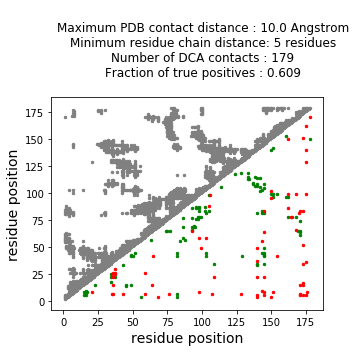


	The reference sequence contains less number of residues compared to PDB chain sequence. 
	Make sure that you have provided correct input data.


dict_keys(['tp', 'fp', 'missing', 'pdb'])
TP contacts:  109
FP contacts:  70
Missing Contacts:  0
PDB Contacts  2731


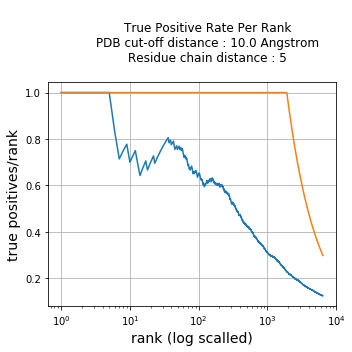

2
6401
6401
AxesSubplot(0.143542,0.137778;0.799648x0.621111)


In [11]:
# Print Details of protein PDB structure Info for contact visualizeation
erdca_plotting = True
if erdca_plotting:
    
    # translate DI indices to pdb range:
    pdb_s_index = np.arange(my_pdb_range[0],my_pdb_range[1])
    pdb_s_index = np.delete(pdb_s_index,cols_removed)
    print(s_index)
    print(pdb_s_index)
    pdb_range_DI = dict()
    for (indx1,indx2), score in erdca_DI:
            if indx1 in s_index and indx2 in s_index:
                pos1 = pdb_s_index[np.where(s_index==indx1)[0][0]] - pdb_range[0]
                pos2 = pdb_s_index[np.where(s_index==indx2)[0][0]] - pdb_range[0]
                indices = (pos1,pos2)
                pdb_range_DI[indices] = score
    print(erdca_DI[:10])
    pdb_range_DI  = sorted(pdb_range_DI.items(), key = lambda k : k[1], reverse=True)
    print(pdb_range_DI[:10])

    print('Using chain ',pdb_chain)
    print('PDB ID: ', pdb_id)

    
    
    from pydca.contact_visualizer import contact_visualizer
    erdca_visualizer = contact_visualizer.DCAVisualizer('protein', pdb_chain, pdb_id,
    refseq_file = pp_ref_file,
    #---------------- DI For Visualization ----------------#                                                    
    sorted_dca_scores = erdca_DI,
    #sorted_dca_scores = pdb_range_DI,
    #------------------------------------------------------#        
    linear_dist = 5,
    contact_dist = 10.)

    
    
    
    er_contact_map_data = erdca_visualizer.plot_contact_map()
    plt.show()
    plt.savefig('contact_map_%s.pdf'%pfam_id)
    print(er_contact_map_data.keys())
    print("TP contacts: ",len(er_contact_map_data['tp']))
    print("FP contacts: ",len(er_contact_map_data['fp']))
    print("Missing Contacts: ",len(er_contact_map_data['missing']))
    print("PDB Contacts ",len(er_contact_map_data['pdb']))


    plt.close()
    er_tp_rate_data = erdca_visualizer.plot_true_positive_rates()
    plt.show()
    print(len(er_tp_rate_data))
    print(len(er_tp_rate_data[0]['dca']))
    print(len(er_tp_rate_data[0]['pdb']))
    print(er_tp_rate_data[1])

    plt.savefig('TP_rate_%s.pdf'%pfam_id)
    plt.close()


Updating contact map to use pdb-refs pdb_start and pdb_end when getting pp sequence coordinates.
#---------------------------------------------------#
Generating Contact Map
#--------------------------------------------------#

['PF02146' '2532' 'Q8I6E4_LEIIN' '39' '223' '5OL0' 'A' '39' '223']
Structure exists: '/home/eclay/DCA_ER/biowulf/ol/pdb5ol0.ent' 
peptide build of chain produced 2 elements
original poly_seq: 
 ['A', 'P', 'H', 'Q', 'E', 'H', 'V', 'L', 'G', 'E', 'P', 'T', 'L', 'E', 'G', 'L', 'A', 'H', 'Y', 'I', 'R', 'E', 'K', 'N', 'V', 'R', 'R', 'I', 'L', 'V', 'L', 'V', 'G', 'A', 'G', 'A', 'S', 'V', 'A', 'A', 'G', 'I', 'P', 'D', 'F', 'R', 'S', 'P', 'D', 'T', 'G', 'I', 'Y', 'A', 'N', 'L', 'G', 'K', 'Y', 'N', 'L', 'E', 'D', 'P', 'T', 'D', 'A', 'F', 'S', 'L', 'T', 'L', 'L', 'R', 'E', 'K', 'P', 'E', 'I', 'F', 'Y', 'S', 'I', 'A', 'R', 'E', 'L', 'N', 'L', 'W', 'P', 'G', 'H', 'F', 'Q', 'P', 'T', 'A', 'V', 'H', 'H', 'F', 'I', 'R', 'L', 'L', 'Q', 'D', 'E', 'G', 'R', 'L', 'L', 'R', 'C', 'C

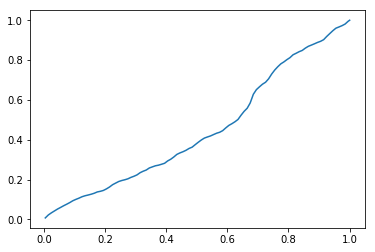

In [18]:
# Updating contact map to use pdb-refs pdb_start and pdb_end when getting pp sequence coordinates.
ct,ct_full,n_amino_full,poly_seq = tools.contact_map(pdb,ipdb,cols_removed,s_index)

print('before distance restr on contact map predicitons\ncontact map shape: ',ct.shape)
# Want to only ROC-analyze positions we made predictions for !!!
ct_predict = np.asarray(tools.distance_restr_ct(ct,s_index,make_large = True))
print('Prediction Contact map shape (distance enforced): ',ct_predict.shape)


#--------------------- Generate DI Matrix ---------------------------#
di = np.zeros((n_amino_full,n_amino_full))
for coupling in erdca_DI:
        #print(coupling[1])
        di[coupling[0][0],coupling[0][1]] = coupling[1]
        di[coupling[0][1],coupling[0][0]] = coupling[1]
#--------------------------------------------------------------------#
# Generate DI matrix of our predictions only    
di_predict = np.zeros((len(s_index),len(s_index)))
for coupling in erdca_DI:
        #print(coupling[1])
        if coupling[0][0] in s_index and coupling[0][1] in s_index:
                di_predict[np.where(s_index==coupling[0][0]),np.where(s_index==coupling[0][1])] = coupling[1]
                di_predict[np.where(s_index==coupling[0][1]),np.where(s_index==coupling[0][0])] = coupling[1]



print('\n\n #------------------ Calculating ROC Curve --------------------#')

#----------------- Generate Optimal ROC Curve -----------------------#
# find optimal threshold of distance for both DCA and ER
ct_thres = np.linspace(1.5,10.,18,endpoint=True)
n = ct_thres.shape[0]

auc = np.zeros(n)




for i in range(n):
        #p,tp,fp = tools.roc_curve(ct_distal,di,ct_thres[i])
        p,tp,fp = tools.roc_curve(ct_full,di,ct_thres[i])
        auc[i] = tp.sum()/tp.shape[0]
i0 = np.argmax(auc)
print('Optimal Distance: ',ct_thres[i0])


# set true positivies, false positives and predictions for optimal distance
p0,tp0,fp0 = tools.roc_curve(ct_full,di,ct_thres[i0])
print(tp0)
print(fp0)
print('AUC: %f'%auc[i0])
plt.plot(fp0,tp0)
plt.show()
